In [1]:
import medmnist
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchio as tio
from torch.autograd import Variable


In [73]:
import os
import subprocess
print(os.listdir())
subprocess.check_call(['test.tex','pdflatex'])

['.ipynb_checkpoints', 'lung_nodule_CNN.ipynb', 'MedMNIST_first_example_network.ipynb', 'test.tex']


OSError: [WinError 193] %1 is not a valid Win32 application

In [2]:
from medmnist import NoduleMNIST3D
dataset = NoduleMNIST3D(split='train',download=True)
n_train = len(dataset)
print(dataset)

Using downloaded and verified file: C:\Users\veedu\.medmnist\nodulemnist3d.npz
Dataset NoduleMNIST3D of size 28 (nodulemnist3d)
    Number of datapoints: 1158
    Root location: C:\Users\veedu\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.
    Licens

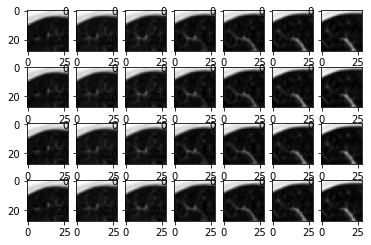

In [3]:
image=dataset[np.random.randint(len(dataset))][0] #
fig,ax = plt.subplots(4,7)
for i in range(4):
    for j in range(7):
        ax[i,j].imshow(image[0][j],cmap='gray')
plt.show()

In [56]:
data_flag = 'nodulemnist3d'
download = False

num_epochs = 40#no. of times the NN is trained on the entire dataset
batch_size = 16 #no. of images before parameters are updated
lr = 0.0005
info = INFO[data_flag]
task = info['task'] #binary classification or multi-classification?
num_channels = info['n_channels'] #colour channels
num_classes = len(info['label']) #number of classes

DataClass = getattr(medmnist, info['python_class'])

In [5]:
transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.ZNormalization(),
])


train_data = DataClass(split='train', transform=transform,download=download)

count=0
for x,y in train_data:
    if y==[0]:
        count+=1
print(count/len(train_data))
weight_0 = n_train/(count*2) 
weight_1 = n_train/((n_train-count)*2)
    
test_data = DataClass(split='test', transform=transform,download=download)

train_loader = data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

0.7452504317789291


In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv3d(num_channels, 28, kernel_size=(3,3,3), padding=1)
        self.conv2 = nn.Conv3d(28, 56, kernel_size=(3,3,3), padding=1)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(76832, 64)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
      # Pass data through conv1
        x = self.conv1(x)
      # Use the rectified-linear activation function over x
        x = F.relu(x)

        #x = self.conv2(x)
        #x = F.relu(x)

        x = F.max_pool3d(x, (2,2,2))
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output
    

GPU Accelerated

In [65]:
import torch

# Check for available GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Move model and tensors to GPU
model = Net().to(device)  # Move model to GPU
weight = torch.tensor([weight_0,weight_1]).to(device)
criterion = nn.CrossEntropyLoss(weight).to(device) # add weight =weight
optimizer = optim.Adam(model.parameters(), lr=lr)

acc_array=np.zeros(num_epochs)
# Move data to GPU inside the loops
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Process target and outputs (on GPU)
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)  # convert to probability
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)  # targets
            y_score = torch.cat((y_score, outputs), 0)  # predicted output + probability

    y_true = y_true.cpu().numpy()  # Move data back to CPU for evaluation
    y_score = y_score.cpu().detach().numpy()

    evaluator = Evaluator(data_flag, 'test')
    auc, acc = evaluator.evaluate(y_score)
    acc_array[epoch] = acc

100%|██████████| 73/73 [00:01<00:00, 52.36it/s]


Text(0, 0.5, 'Acc')

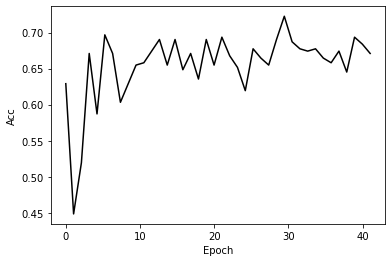

In [66]:
n=np.linspace(0,num_epochs+1,num_epochs)
plt.plot(n,acc_array,color='black')
plt.xlabel('Epoch')
plt.ylabel('Acc')